<a href="https://colab.research.google.com/github/zhlu97/foundationcv/blob/master/EECS_504_Pset_3_Motion_Magnification_and_Texture_Synthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EECS 504 PS3: Motion Magnification and Texture Synthesis

Please provide the following information 
(e.g. Andrew Owens, ahowens):

[Zhaohan] [Lu], [zhaohan]




# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the notebook to your local machine as a .ipynb file for Canvas submission.

In [ ]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import math

import random
import sys
from scipy import ndimage

# cv2.imshow does not work in Colab, we use cv2_imshow instead
from google.colab.patches import cv2_imshow

In [ ]:
%%capture
# download some images
# should take a second to run

# for motion magnification problem
! wget -O bill.avi "https://drive.google.com/uc?export=download&id=1QR2dCShn-fYYEvcAQ8J4mnIo_ISqrjc7"

# for texture synthesis problem
! wget -O texture.jpg "https://drive.google.com/uc?export=download&id=11IlTZNLwfYsXQt2L1GbKdNqcj6JNkQik"
! wget -O rings.jpg "https://drive.google.com/uc?export=download&id=1fYtmQe_a40BWg1OU178SFbcU4KRZuphn"
! wget -O jigsaw.jpg "https://drive.google.com/uc?export=download&id=1SlYUw6vT9_PNP8XNhQfAu36AtPJ-PMpk"

## **Problem 3.1 (a)**

In [ ]:
def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

In [ ]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4;

# horizontal movement from (0, 0) to (0, 1)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1

ff1 = fftshift(fft2(im1))
ff2 = fftshift(fft2(im2))


### This is a quick tutorial for those who are not familiar with complex numbers in python.

In [ ]:
# create a complex number
x = 1 + 1j
print("x =", x)
print("x.real", x.real, "x.imag", x.imag)

# magnitude and phase of complex number
mag = abs(x)
phase = angle(x)

print("Magnitude", mag)
print("Phase", phase)

# Euler's formula
y = mag * exp(phase * 1j)
print("y =", y)

x = (1+1j)
x.real 1.0 x.imag 1.0
Magnitude 1.4142135623730951
Phase 0.7853981633974483
y = (1.0000000000000002+1j)


In [ ]:
def magnify_change(im1, im2, magnification_factor):
    
    # find phase shift in frequency domain
    im1_dft = fft2(im1)
    im2_dft = fft2(im2)
    phase_shift = angle(im2_dft) - angle(im1_dft)#TODO1
    
    # magnify the phase change in frequency domain 
    magnified_dft = abs(im1_dft) * exp((magnification_factor * phase_shift + angle(im1_dft)) * 1j)#TODO2
    
    # what does the magnified phase change cause in image space?
    magnified = ifft2(magnified_dft).real
    
    return magnified

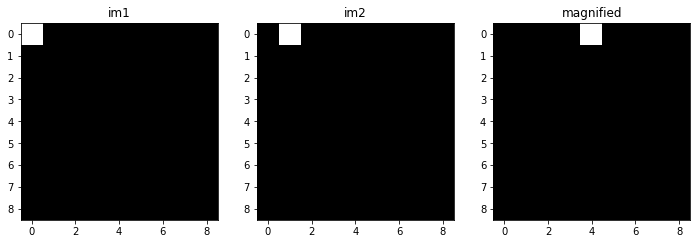

In [ ]:
# magnify position change
magnified = magnify_change(im1, im2, magnification_factor);

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');

## **Problem 3.1 (b)**


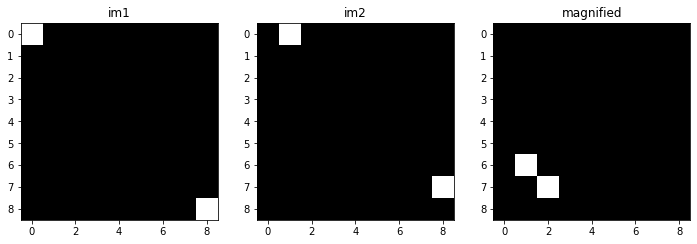

In [ ]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# magnify position change
magnified = magnify_change(im1, im2, magnification_factor)


plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');


The two offsets were not properly magnified because we are using DFT to compute the phase shift, but the phase of the new images are not seperated into 2 blocks (the phase of the new signal is not simply combined the signals of 2 blocks). Therefore, the magnified result is not the superposition of the 1-d difference images.

## **Problem 3.1 (c)**


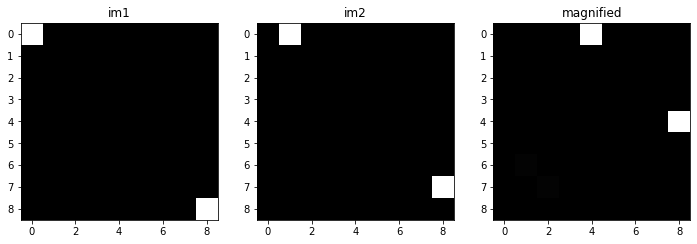

In [ ]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# width of our Gaussian window
sigma = 2

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# we will magnify windows of the image and aggregate the results
magnified = np.zeros([im_size, im_size])

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(im_size), np.arange(im_size))

for y in range(0, im_size, 2*sigma):
    for x in range(0, im_size, 2*sigma):
        gaussian_mask = 1/(2 * np.pi * sigma**2) * exp(-((X - x)**2 + (Y - y)**2)/(2 * sigma**2))#TODO3
        window_magnified = magnify_change(im1 * gaussian_mask, im2 * gaussian_mask,
                                          magnification_factor)
        
        magnified = magnified + window_magnified

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');

## **Problem 3.1 (d) - Motion Magnification**


In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture('bill.avi')

# list of video frames
frames = []

while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()
    
    if ret is False:
        break

    frame = cv2.resize(frame, (200, 200), interpolation=cv2.INTER_CUBIC)
    frames.append(frame)

cap.release()

# scale frame to 0-1
frames = np.array(frames) / 255.
print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

# get height, width
num_frames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

frames size: (60, 200, 200, 3) # (nb_frames, height, width, channel)


In [ ]:
# 10x magnification of motion
magnification_factor = 10

# width of Gaussian window
sigma = 26

# alpha for moving average
alpha = 0.5

# we will magnify windows of the video and aggregate the results
magnified = np.zeros_like(frames)

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(width), np.arange(height))

# iterate over windows of the frames
x_range = list(range(0, width, 2*sigma))
y_range = list(range(0, height, 2*sigma))
num_windows = len(x_range) * len(y_range)
window_index = 1

for y in y_range:
    for x in x_range:
        for channel_index in range(3): # RGB channels
            for frame_index in range(num_frames):
                
                # create windowed frames
                gaussian_mask = 1/(2 * np.pi * sigma**2) * exp(-(x**2 + y**2)/(2 * sigma**2))#TODO5
                windowed_frames = gaussian_mask * frames[frame_index,:,:,channel_index]
            
                # initialize moving average of phase for current window/channel
                if frame_index == 0:
                    window_average_phase = angle(fft2(windowed_frames))
                
                window_dft = fft2(windowed_frames)
                
                # compute phase shift and constrain to [-pi, pi] since
                # angle space wraps around
                window_phase_shift = angle(window_dft) - window_average_phase
                window_phase_shift[window_phase_shift > pi] = window_phase_shift[window_phase_shift > pi] - 2 * pi
                window_phase_shift[window_phase_shift < -pi] = window_phase_shift[window_phase_shift < -pi] + 2 * pi
                
                # magnify phase shift
                window_magnified_phase = magnification_factor * window_phase_shift + angle(window_dft)#TODO6
                 
                # go back to image space
                window_magnified_dft = abs(window_dft) * exp(window_magnified_phase * 1j)#TODO7
                window_magnified = abs(ifft2(window_magnified_dft))
                
                # update moving average
                window_phase_unwrapped = window_average_phase + window_phase_shift
                window_average_phase = alpha * window_average_phase + (1 - alpha) * window_phase_unwrapped
                
                # aggregate
                magnified[frame_index,:,:,channel_index] = magnified[frame_index,:,:,channel_index] + window_magnified
        
        # print progress
        print('{}/{}'.format(window_index, num_windows))
        window_index += 1

1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
16/16


In [ ]:
outputs = magnified / np.max(magnified)
for channel_index in range(3):
    original_frame = frames[0,:,:,channel_index]
    magnified_frame = outputs[0,:,:,channel_index]
    scale = np.std(original_frame[:]) / np.std(magnified_frame[:])
    original_mean = np.mean(original_frame[:])
    magnified_mean = np.mean(magnified_frame[:])
    outputs[:,:,:,channel_index] = magnified_mean + scale * (outputs[:,:,:,channel_index] - magnified_mean)

outputs = np.clip(outputs, 0, 1)

In [ ]:
# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('bill_magnified.avi',fourcc, 30.0, (height, width))

for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = (np.clip(outputs[i], 0, 1) * 255).astype(np.uint8)
    
    # write frame to output video
    out.write(frame)

out.release()

In [ ]:
# Only for colab downloading videos
try:
    from google.colab import files
    files.download('bill_magnified.avi')
except:
    print("Only for google colab")

## **Problem 3.2 - Texture Synthesis**

Note that the functions provided below are templates. Feel free to add your own helper functions as needed.

You can reference the pseudocode provided here:  https://people.eecs.berkeley.edu/~efros/research/NPS/alg.html.

### Find matches function

In [ ]:
def find_matches(template, sample, gauss_mask, valid_mask, window):
    half = int((window -1)/2)
    epsilon = 0.1
   
    total_weight = np.sum(np.multiply(gauss_mask, valid_mask))
    SSD = np.zeros((sample.shape[0], sample.shape[1]))

    sample_padded = np.pad(sample, ([half,half],[half,half],[0,0]), 'constant', constant_values=0)
    for i in range(half, sample.shape[0] + half):
      for j in range(half, sample.shape[1] + half):
        dist = (np.sum(template[:,:,:] - sample_padded[(i-half):(i+half+1), (j-half):(j+half+1),:], axis=2))**2
        cor = np.correlate(np.reshape(dist, window**2), np.reshape(np.multiply(gauss_mask, valid_mask),window**2))[0]
        SSD[i - half, j - half] = cor/total_weight

    min_ssd = SSD.min()
    PixelList = []
    for i in range(sample.shape[0]):
      for j in range(sample.shape[1]):
        if(SSD[i, j] <= min_ssd * (1 + epsilon)):
          PixelList.append([i, j, SSD[i, j]])

    return PixelList


### Synthesize texture function

In [ ]:
def synth_texture(sample, window_size, out_size):
    delta = 0.3
    half_window = (int) (math.floor(window_size / 2))
    # normalize pixel intensity
    sample = sample.astype(np.float64)
    sample = sample / 255.0
    seed_size = 3
    [sheight, swidth, channels] = sample.shape
    synth_img = np.zeros((*out_size, channels))

    # initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image
    rh = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    rw = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    center = [round(.5 * x) for x in out_size] # center
    synth_img[center[0]: center[0] + seed_size, center[1]: center[1] + seed_size ,:] = sample[rh: rh + seed_size , rw: rw + seed_size,:]

    # bitmap indicating filled pixels, the seed patch is initially filled
    filled = np.zeros(out_size)
    filled[center[0]: center[0] + seed_size , center[1]: center[1] + seed_size] = 1
    num_filled = int(np.sum(filled))
    n_pixels = out_size[0]*out_size[1]

    # TODO
    # intialize 2D zero-mean gaussian w/ variance = (window_size / 6.4)
    gx = np.linspace(-(window_size - 1) / 2., (window_size - 1) / 2., window_size)
    xx, yy = np.meshgrid(gx, gx)
    k  = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(window_size / 6.4))
    gauss_mask = k / np.sum(k)

    # # main loop: repeat until all pixels are filled
    next_p = n_pixels / 10
    
    synth_padded = np.pad(synth_img,([half_window,half_window],[half_window,half_window], [0,0]),'constant', constant_values=0)
    filled_padded = np.pad(filled, ([half_window,half_window],[half_window,half_window]), 'constant', constant_values=0)

    # main loop: repeat until all pixels are filled
    next_p = n_pixels / 10
    while(num_filled < n_pixels):
        progress = 0
        if(num_filled > next_p):
            print(round(100 * num_filled / n_pixels), '% complete')
            next_p += n_pixels / 10

        # TODO:
        # get list of unfilled pixels as (x, y) coordinates
        # hint: use dilation and masking to efficiently find unfilled neighboring pixels
        pixel_list = []
        dilation = ndimage.binary_dilation(filled).astype(filled.dtype) - filled
        for x in range(out_size[0]):
          for y in range(out_size[1]):
            if(dilation[x][y] != 0):
              pixel_list.append([x, y])
        for x, y in pixel_list:
          # TODO:
          # place window with center as (x, y) and use as template
          template = synth_padded[x : (x + window_size), y : (y + window_size), :]
          valid_mask = filled_padded[x : (x + window_size), y : (y + window_size)]
          # TODO:
          # find the best matching windows from sample image
          # randomly sample one from best matches
          best_matches = find_matches(template, sample, gauss_mask, valid_mask, window_size)
          rnd_index = random.randint(0, len(best_matches) - 1)
          # rnd_index = np.random.choice(len(best_matches))
          best_match = best_matches[rnd_index]
          if(best_match[2] < delta):
            synth_img[x, y, :] = sample[best_match[0], best_match[1], :]
            synth_padded[x + half_window,y + half_window,:] = sample[best_match[0], best_match[1], :]
            filled_padded[x + half_window,y + half_window] = 1
            filled[x, y] = 1
            progress = 1
            num_filled = num_filled + 1        
        if(progress == 0):
          delta = delta * 1.1

    synth_img = synth_img * 255
    return synth_img

### Main function

Run the texture synthesis algorithm to generate texture of new shape. 

Source Image


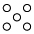

10 % complete
22 % complete
30 % complete
40 % complete
52 % complete
63 % complete
72 % complete
80 % complete
91 % complete
Target Image


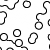

10 % complete
22 % complete
30 % complete
40 % complete
52 % complete


KeyboardInterrupt: ignored

In [ ]:
# Texture synthesis on rings
source = cv2.imread('rings.jpg')
window_sizes = [5, 7, 13] 
out_size = [50, 50]

print('Source Image')
cv2_imshow(source)

for w in window_sizes:
  target = synth_texture(source, w, out_size)
  print('Target Image')
  cv2_imshow(target)



Source Image


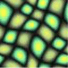

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
Target Image


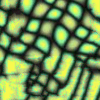

In [ ]:
w = 5

#Texture synthesis on colored image
source = cv2.imread('texture.jpg')
print('Source Image')
cv2_imshow(source)
target = synth_texture(source, w, out_size)
print('Target Image')
cv2_imshow(target)

# Don't need to submit this one
# source = cv2.imread('jigsaw.jpg')
# print('Source Image')
# cv2_imshow(source)
# target = synth_texture(source, w, out_size)
# print('Target Image')
# cv2_imshow(target)

1. Explain the algorithm's performance with respect to window size:

The larger the window size, the better the synthesized result. This is probably because a larger window size means looking for more neighbours having the same pattern, and a more similar pixel will be found leading to a more precise result. However, as the window size gets larger, the run time also increase greatly. More computations are needed and these is the tradeoff between the result and run time cost.

2. For a given window size, if you re-run the algorithm with the same starting seed do you get the same result? Why or why not? Is this true for all window sizes?

I did not get the same result when re-running the program. This is because every time we are choosing the best_match randomly from a list of best_matches. They are all in the same boundary, but varies slightly so that they could produce different results.

This is true for all window sizes.
